# Project 1 

## Do Returns to Experience Diminish at Higher Wage Levels? Evidence from a Selection-Corrected Wage Equation for Married Women


---


Ian Solberg

Professor Richeng Piao 

---

 **execution only notebook** 
 
 `data_handling.py` contains data decisions and useful functions for simplifying model assignments*

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_handling import MrozHandler

FILEPATH = "data/Mroz.csv"

Mroz = MrozHandler(FILEPATH)

Full dataset shape
Number of rows: 753
Number of features: 22
Working subset shape:
Number of rows: 428
Number of features: 22


## Stage 1 Probit

---

In [10]:
import statsmodels.api as sm

Mroz.set_dependent("work", full=True)
Mroz.add_independents("kidslt6", "nwifeinc", "educ", "agew", "motheduc", "fatheduc", full=True)

probit_result = sm.Probit(Mroz.get_y().astype(int), Mroz.get_X()).fit()
print(probit_result.summary())

Dependent variable set to: work
Independent variables: ['kidslt6', 'nwifeinc', 'educ', 'agew', 'motheduc', 'fatheduc']
Optimization terminated successfully.
         Current function value: 0.603822
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                   work   No. Observations:                  753
Model:                         Probit   Df Residuals:                      746
Method:                           MLE   Df Model:                            6
Date:                Wed, 25 Feb 2026   Pseudo R-squ.:                  0.1169
Time:                        15:53:00   Log-Likelihood:                -454.68
converged:                       True   LL-Null:                       -514.87
Covariance Type:            nonrobust   LLR p-value:                 1.349e-23
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

#### Attach Inverse-Mills Ratio Vector to MROZ dataset

In [11]:
from scipy.stats import norm
fitted = probit_result.fittedvalues
Mroz.attach("IMR", norm.pdf(fitted)/norm.cdf(fitted))

Attached 'IMR' to dataset


## Stage 2 OLS - With Stage 1 IMF

---

In [12]:
def heckman_object(Mroz: MrozHandler) -> tuple[pd.Series, pd.DataFrame, MrozHandler]:
    Mroz.clear_caches()
    Mroz.set_dependent("lwage", full=False)
    Mroz.add_independents("exper", "expersq", full=False)
    Mroz.add_controls("educ", "kidslt6", "nwifeinc", "IMR", full=False)
    y = Mroz.get_y().dropna() # Fix the log wage issue by dropping nans, which correspond to non-working individuals
    X = Mroz.get_X().loc[y.index] # Ensure X and y are aligned after dropping nans
    return y, X, Mroz

y, X, HeckmanMroz = heckman_object(Mroz)
ols_result = sm.OLS(y, X).fit()
print(ols_result.summary())

Caches cleared
Dependent variable set to: lwage
Independent variables: ['exper', 'expersq']
Control variables: ['educ', 'kidslt6', 'nwifeinc', 'IMR']
                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     13.69
Date:                Wed, 25 Feb 2026   Prob (F-statistic):           3.16e-14
Time:                        15:53:00   Log-Likelihood:                -429.95
No. Observations:                 428   AIC:                             873.9
Df Residuals:                     421   BIC:                             902.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      

## Baseline OLS Validation - Without IMF

---

In [13]:
def baseline_object(Mroz: MrozHandler) -> tuple[pd.Series, pd.DataFrame, MrozHandler]:
    Mroz.clear_caches()
    Mroz.set_dependent("lwage", full=False)
    Mroz.add_independents("exper", "expersq", full=False)
    Mroz.add_controls("educ", "kidslt6", "nwifeinc", full=False)
    y = Mroz.get_y().dropna()
    X = Mroz.get_X().loc[y.index]
    return y, X, Mroz
    
y, X, BaselineMroz = baseline_object(Mroz)
ols_baseline = sm.OLS(y, X).fit()
print(ols_baseline.summary())

Caches cleared
Dependent variable set to: lwage
Independent variables: ['exper', 'expersq']
Control variables: ['educ', 'kidslt6', 'nwifeinc']
                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     16.47
Date:                Wed, 25 Feb 2026   Prob (F-statistic):           7.32e-15
Time:                        15:53:01   Log-Likelihood:                -429.95
No. Observations:                 428   AIC:                             871.9
Df Residuals:                     422   BIC:                             896.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

### Stage 2 — Baseline OLS vs Heckman-Corrected OLS (N=428)

| Variable | Baseline OLS | p-val | Heckman OLS | p-val |
|---|---|---|---|---|
| Constant | -0.5423 | 0.007 | -0.5233 | 0.197 |
| exper | 0.0417 | 0.002 | 0.0417 | 0.002 |
| expersq | -0.0008 | 0.044 | -0.0008 | 0.049 |
| educ | 0.0995 | 0.000 | 0.0983 | 0.000 |
| kidslt6 | -0.0391 | 0.645 | -0.0333 | 0.808 |
| nwifeinc | 0.0077 | 0.092 | 0.0079 | 0.199 |
| IMR | — | — | -0.0138 | 0.957 |

## Experience-Wage Curve:

---

Plotting experience-earnings curves... 

Panel 1: Log Wage (Heckman Corrected)

Caches cleared
Dependent variable set to: lwage
Independent variables: ['exper', 'expersq']
Control variables: ['educ', 'kidslt6', 'nwifeinc', 'IMR']

Panel 2: Levels Wage - No IMR (Baseline)

Dependent variable set to: hearnw
Independent variables: ['exper', 'expersq', 'exper', 'expersq']
Control variables: ['educ', 'kidslt6', 'nwifeinc', 'IMR', 'educ', 'kidslt6', 'nwifeinc']


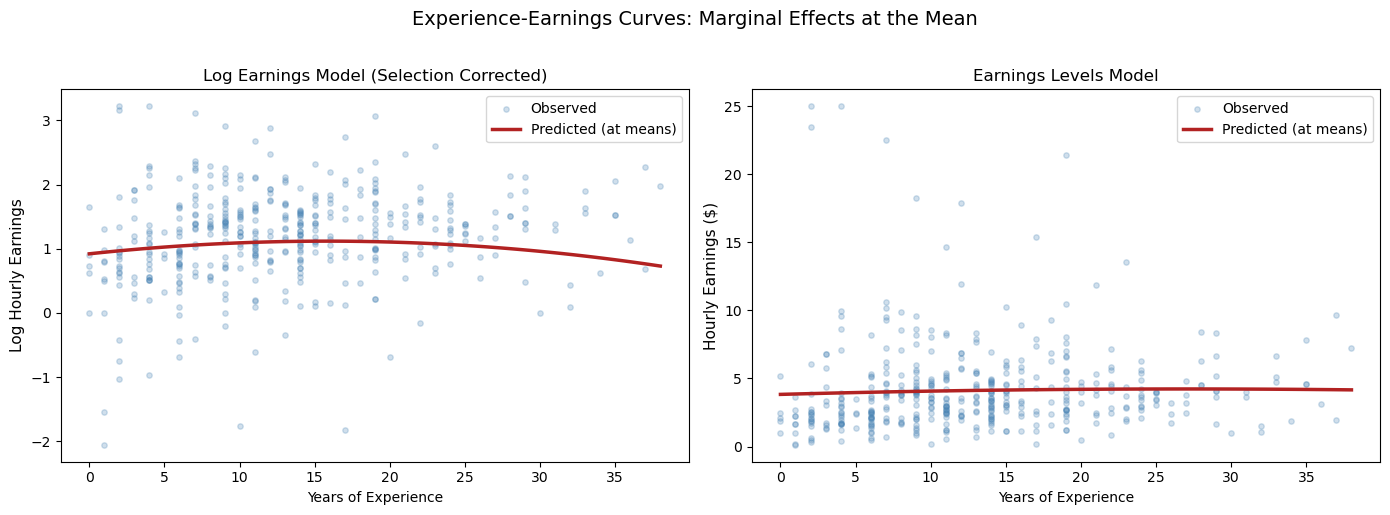

In [14]:
def plot_experience_curve(handler, model_result, dep_var_label, ax):
    # 1. Create a range for Experience
    max_exp = handler.working["exper"].max()
    exper_range = np.linspace(0, max_exp, 100)
    
    # 2. Get the average values of all regressors used in the model
    X_means = model_result.model.exog.mean(axis=0)
    X_pred = pd.DataFrame([X_means] * 100, columns=model_result.params.index)
    
    # 3. Update only the experience columns
    X_pred["exper"] = exper_range
    X_pred["expersq"] = exper_range**2
    
    # 4. Predict
    y_pred = model_result.predict(X_pred)
    
    # 5. Plot
    observed = handler.working[dep_var_label].dropna()
    ax.scatter(handler.working["exper"], observed, alpha=0.25, color="steelblue", s=15, label="Observed")
    ax.plot(exper_range, y_pred, color="firebrick", linewidth=2.5, label="Predicted (at means)")
    ax.set_xlabel("Years of Experience")
    ax.legend()

# ==== Execution Block ====

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
print("Plotting experience-earnings curves... \n")
print("Panel 1: Log Wage (Heckman Corrected)\n")

# Panel 1: Log Wage (Heckman Corrected)

y_log, X_log, _ = heckman_object(Mroz)
ols_log = sm.OLS(y_log, X_log).fit()

plot_experience_curve(Mroz, ols_log, "lwage", axes[0])
axes[0].set_ylabel("Log Hourly Earnings", fontsize=11)
axes[0].set_title("Log Earnings Model (Selection Corrected)")

# Panel 2: Levels Wage (Baseline)

print("\nPanel 2: Levels Wage - No IMR (Baseline)\n")
Mroz.set_dependent("hearnw", full=False)
Mroz.add_independents("exper", "expersq", full=False)
Mroz.add_controls("educ", "kidslt6", "nwifeinc", full=False)

y_lvl = Mroz.get_y().dropna()   
X_lvl = Mroz.get_X().loc[y_lvl.index]
ols_levels = sm.OLS(y_lvl, X_lvl).fit()

plot_experience_curve(Mroz, ols_levels, "hearnw", axes[1])
axes[1].set_ylabel("Hourly Earnings ($)", fontsize=11)
axes[1].set_title("Earnings Levels Model", fontsize=12)

fig.suptitle("Experience-Earnings Curves: Marginal Effects at the Mean", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()